Based on examples found in
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')
from timeit import default_timer as timer

from sklearn import metrics, model_selection, preprocessing 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from itertools import cycle, islice

import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

In [2]:
 path = "../data"

pulsar_data = pd.read_csv(path + "/input/HTRU2/HTRU_2.csv", 
                          low_memory=False, index_col=False, header=0, 
                          names=["mean_IP", "standDev_IP", "excessKurt_IP", "skewness_IP", 
                                 "mean_DMSNR", "standDev_DMSNR", "excessKurt_DMSNR", "skewness_DMSNR", "pulsar"])

features= pulsar_data.drop('pulsar', axis = 1)
feature_list = list(features.columns)

# print(pulsar_data.head())

In [3]:
 confirmed_pulsar = pulsar_data[pulsar_data['pulsar'] == 1]
confirmed_noise = pulsar_data[pulsar_data['pulsar'] == 0]

# print(confirmed_pulsar.head())
# print(confirmed_noise.head()) 

In [4]:
positive_train_paper_split = confirmed_pulsar.iloc[:200]
negative_train_paper_split = confirmed_noise.iloc[:200]
positive_test_paper_split = confirmed_pulsar.iloc[200:]
negative_test_paper_split = confirmed_noise.iloc[200:]

train_paper_split = pd.concat([positive_train_paper_split, negative_train_paper_split],
                               ignore_index=True, sort=False)
test_paper_split = pd.concat([positive_test_paper_split, negative_test_paper_split],
                               ignore_index=True, sort=False)

train_paper_split = train_paper_split.sample(frac=1).reset_index(drop=True)
test_paper_split = test_paper_split.sample(frac=1).reset_index(drop=True)

X_train_paper_split = train_paper_split.iloc[:, :8]
X_test_paper_split = test_paper_split.iloc[:, :8]
y_train_paper_split = train_paper_split.iloc[:, 8]
y_test_paper_split = test_paper_split.iloc[:, 8]

# print(X_train_paper_split.shape)
# print(X_train_paper_split.head())
# print(X_test_paper_split.shape)
# print(X_test_paper_split.head())
# print(y_train_paper_split.shape)
# print(y_train_paper_split.head())
# print(y_test_paper_split.shape)
# print(y_test_paper_split.head())

In [5]:
 X, y = pulsar_data.iloc[:, :8], pulsar_data.iloc[:, 8]

# print(X.head())
# print(y.head())

In [6]:
X_train_3fold, X_test_3fold, y_train_3fold, y_test_3fold = model_selection.train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [7]:
X_train_5fold, X_test_5fold, y_train_5fold, y_test_5fold = model_selection.train_test_split(X, y, test_size=0.2, 
                                                                            random_state=42, stratify=y)

In [8]:
X_train_10fold, X_test_10fold, y_train_10fold, y_test_10fold = model_selection.train_test_split(X, y, test_size=0.1, 
                                                                            random_state=42, stratify=y)

Paper Split

In [9]:
params = {
        'n_estimators': [10, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        }

skf =  model_selection.StratifiedKFold(n_splits=2, shuffle = True, random_state=42)

rf = RandomForestClassifier()

grid =  model_selection.GridSearchCV(estimator=rf, param_grid=params, scoring='f1', n_jobs=-1, 
                                     cv=skf.split(X_train_paper_split, y_train_paper_split), 
                                     verbose=3)

startTrain = timer()
model_ps = grid.fit(X_train_paper_split, y_train_paper_split)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
5.258724972999971


In [10]:
y_pred_ps = model_ps.predict(X_test_paper_split)
predictions_ps = [round(value) for value in y_pred_ps]

accuracy = metrics.accuracy_score(y_test_paper_split, predictions_ps)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.94%


Random Forest Confusion matrix: Paper Split
[[14922  1136]
 [  100  1339]]


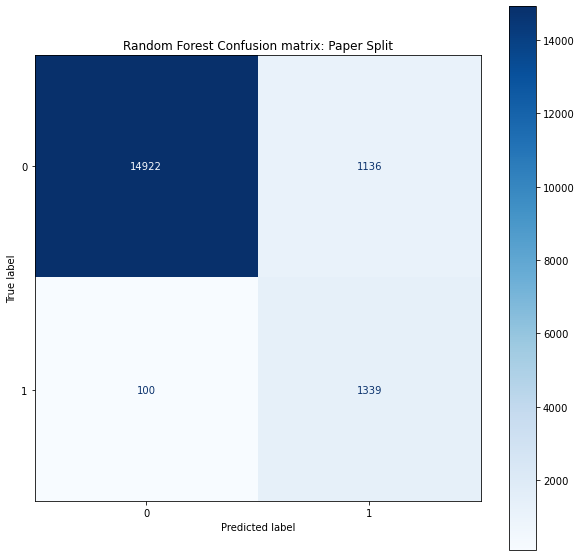

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]
disp = metrics.plot_confusion_matrix(model_ps, X_test_paper_split, 
                                     y_test_paper_split, cmap=plt.cm.Blues)
title = "Random Forest Confusion matrix: Paper Split"
disp.ax_.set_title(title)

TP = disp.confusion_matrix[0][0]
FP = disp.confusion_matrix[0][1]
FN = disp.confusion_matrix[1][0]
TN = disp.confusion_matrix[1][1]
conf_matrix_ps = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, }

print(title)
print(disp.confusion_matrix)

plt.savefig(path + '/output/rf_paper_split_conf_mat.png', bbox_inches='tight')
plt.show()


3-Fold

In [12]:
positive_weight = 16258/1639 # recommended method for findinng positve weight for imbalanced data

params = {
        'n_estimators': [10, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        }

skf =  model_selection.StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

rf = RandomForestClassifier()

grid =  model_selection.GridSearchCV(estimator=rf, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_3fold, y_train_3fold), verbose=3)

startTrain = timer()
model_3f = grid.fit(X_train_3fold, y_train_3fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
42.20994265499996


In [13]:
# print(grid.best_params_)

In [14]:
# print(grid.best_estimator_) 

In [15]:
y_pred_3f = model_3f.predict(X_test_3fold)
predictions3 = [round(value) for value in y_pred_3f]

# accuracy = metrics.accuracy_score(y_test_3fold, predictions3)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [16]:
auc = metrics.roc_auc_score(y_test_3fold, predictions3)
# print("auc: %.2f%%" % (auc * 100.0))

Random Forest Confusion matrix: 3 Fold CV
[[5323   43]
 [  76  465]]


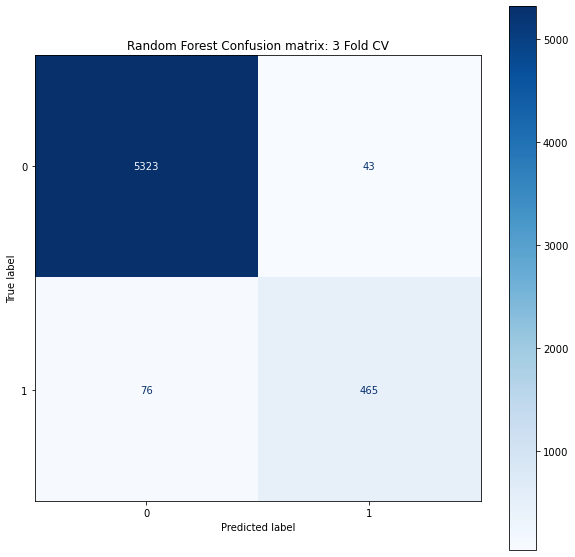

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]
disp = metrics.plot_confusion_matrix(model_3f, X_test_3fold, y_test_3fold,
                                 cmap=plt.cm.Blues)
title = "Random Forest Confusion matrix: 3 Fold CV"
disp.ax_.set_title(title)

TP = disp.confusion_matrix[0][0]
FP = disp.confusion_matrix[0][1]
FN = disp.confusion_matrix[1][0]
TN = disp.confusion_matrix[1][1]
conf_matrix_3f = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, }

print(title)
print(disp.confusion_matrix)

plt.savefig(path + '/output/rf_3_fold_conf_mat.png', bbox_inches='tight')
plt.show()

5 Fold

In [18]:
params = {
        'n_estimators': [10, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        }

skf =  model_selection.StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

rf = RandomForestClassifier()

grid =  model_selection.GridSearchCV(estimator=rf, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_5fold, y_train_5fold), verbose=3)

startTrain = timer()
model_5f = grid.fit(X_train_5fold, y_train_5fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
100.73994325499996


In [19]:
print(grid.best_params_)

{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 200}


In [20]:
print(grid.best_estimator_)

RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=200)


In [21]:
y_pred_5f = model_5f.predict(X_test_5fold)
predictions5 = [round(value) for value in y_pred_5f]

accuracy = metrics.accuracy_score(y_test_5fold, predictions5)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.91%


In [22]:
auc = metrics.roc_auc_score(y_test_5fold, predictions5)
print("auc: %.2f%%" % (auc * 100.0))

auc: 92.54%


Random Forest Confusion matrix: 5 Fold CV
[[3223   29]
 [  46  282]]


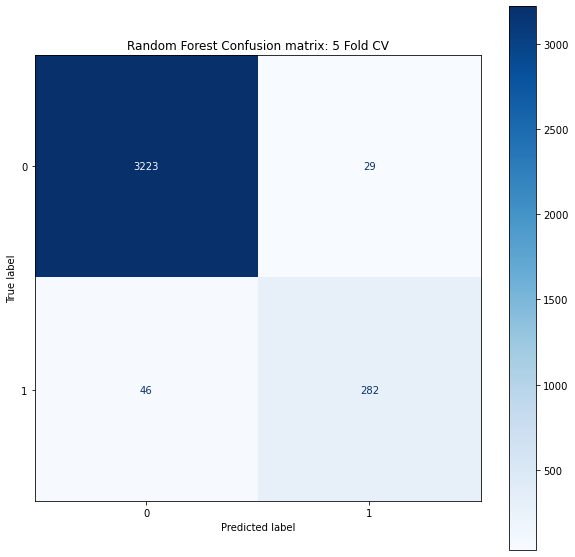

In [23]:
plt.rcParams['figure.figsize'] = [10, 10]
disp = metrics.plot_confusion_matrix(model_5f, X_test_5fold, y_test_5fold,
                                 cmap=plt.cm.Blues)
title = "Random Forest Confusion matrix: 5 Fold CV"
disp.ax_.set_title(title)

TP = disp.confusion_matrix[0][0]
FP = disp.confusion_matrix[0][1]
FN = disp.confusion_matrix[1][0]
TN = disp.confusion_matrix[1][1]
conf_matrix_5f = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, }

print(title)
print(disp.confusion_matrix)

plt.savefig(path + '/output/rf_5_fold_conf_mat.png', bbox_inches='tight')
plt.show()

10 Fold

In [24]:
params = {
        'n_estimators': [10, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        }

skf =  model_selection.StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

rf = RandomForestClassifier()

grid =  model_selection.GridSearchCV(estimator=rf, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_10fold, y_train_10fold), verbose=3)

startTrain = timer()
model_10f = grid.fit(X_train_10fold, y_train_10fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
251.47213206499998


In [25]:
y_pred_10f = model_10f.predict(X_test_10fold)
predictions10 = [round(value) for value in y_pred_10f]

Random Forest Confusion matrix: 10 Fold CV
[[1609   17]
 [  24  140]]


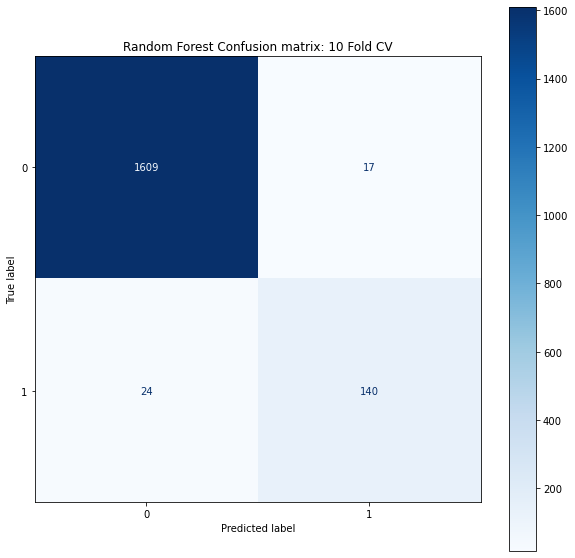

In [26]:
plt.rcParams['figure.figsize'] = [10, 10]
disp = metrics.plot_confusion_matrix(model_10f, X_test_10fold, y_test_10fold,
                                 cmap=plt.cm.Blues)
title = "Random Forest Confusion matrix: 10 Fold CV"
disp.ax_.set_title(title)

TP = disp.confusion_matrix[0][0]
FP = disp.confusion_matrix[0][1]
FN = disp.confusion_matrix[1][0]
TN = disp.confusion_matrix[1][1]
conf_matrix_10f = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN, }

print(title)
print(disp.confusion_matrix)

plt.savefig(path + '/output/rf_10_fold_conf_mat.png', bbox_inches='tight')
plt.show()

Output to CSV

In [27]:
# Paper Split - conf_matrix_ps
ps_fscore = metrics.f1_score(y_test_paper_split, predictions_ps)
ps_recall = metrics.recall_score(y_test_paper_split, predictions_ps)
ps_precision = metrics.precision_score(y_test_paper_split, predictions_ps)
ps_specificity = conf_matrix_ps['TN']/(conf_matrix_ps['TN']+conf_matrix_ps['FP'])
ps_fpr = conf_matrix_ps['FP']/(conf_matrix_ps['FP']+conf_matrix_ps['TN'])
ps_accuracy = metrics.accuracy_score(y_test_paper_split, predictions_ps)
ps_gmean = math.sqrt(ps_precision*ps_recall)

ps_dict = {'data_set' : 'HTRU 2', 'Algorithm' : 'Random Forest', 
           'G-Mean' : [ps_gmean], 'fscore' : [ps_fscore], 'recall' : [ps_recall], 
           'precision' : [ps_precision], 'specificity' : [ps_specificity], 
           'fpr' : [ps_fpr], 'accuracy' : [ps_accuracy]}

ps_df = pd.DataFrame(data=ps_dict)
ps_df.to_csv(path + '/output/rf_paper_split_metrics.csv', index = False, header=True)

# 3 Fold - conf_matrix_3f
f3_fscore = metrics.f1_score(y_test_3fold, predictions3)
f3_recall = metrics.recall_score(y_test_3fold, predictions3)
f3_precision = metrics.precision_score(y_test_3fold, predictions3)
f3_specificity = conf_matrix_3f['TN']/(conf_matrix_3f['TN']+conf_matrix_3f['FP'])
f3_fpr = conf_matrix_3f['FP']/(conf_matrix_3f['FP']+conf_matrix_3f['TN'])
f3_accuracy = metrics.accuracy_score(y_test_3fold, predictions3)
f3_gmean = math.sqrt(f3_precision*f3_recall)

f3_dict = {'data_set' : 'HTRU 2', 'Algorithm' : 'Random Forest', 
           'G-Mean' : [f3_gmean], 'fscore' : [f3_fscore], 'recall' : [f3_recall], 
           'precision' : [f3_precision], 'specificity' : [f3_specificity], 
           'fpr' : [f3_fpr], 'accuracy' : [f3_accuracy]}

f3_df = pd.DataFrame(data=f3_dict)
f3_df.to_csv(path + '/output/rf_3_fold_metrics.csv', index = False, header=True)

# 5 Fold - conf_matrix_5f
f5_fscore = metrics.f1_score(y_test_5fold, predictions5)
f5_recall = metrics.recall_score(y_test_5fold, predictions5)
f5_precision = metrics.precision_score(y_test_5fold, predictions5)
f5_specificity = conf_matrix_5f['TN']/(conf_matrix_5f['TN']+conf_matrix_5f['FP'])
f5_fpr = conf_matrix_5f['FP']/(conf_matrix_5f['FP']+conf_matrix_5f['TN'])
f5_accuracy = metrics.accuracy_score(y_test_5fold, predictions5)
f5_gmean = math.sqrt(f5_precision*f5_recall)

f5_dict = {'data_set' : 'HTRU 2', 'Algorithm' : 'Random Forest', 
           'G-Mean' : [f5_gmean], 'fscore' : [f5_fscore], 'recall' : [f5_recall], 
           'precision' : [f5_precision], 'specificity' : [f5_specificity], 
           'fpr' : [f5_fpr], 'accuracy' : [f5_accuracy]}

f5_df = pd.DataFrame(data=f5_dict)
f5_df.to_csv(path + '/output/rf_5_fold_metrics.csv', index = False, header=True)

# 10 Fold - conf_matrix_10f
f10_fscore = metrics.f1_score(y_test_10fold, predictions10)
f10_recall = metrics.recall_score(y_test_10fold, predictions10)
f10_precision = metrics.precision_score(y_test_10fold, predictions10)
f10_specificity = conf_matrix_10f['TN']/(conf_matrix_10f['TN']+conf_matrix_10f['FP'])
f10_fpr = conf_matrix_10f['FP']/(conf_matrix_10f['FP']+conf_matrix_10f['TN'])
f10_accuracy = metrics.accuracy_score(y_test_10fold, predictions10)
f10_gmean = math.sqrt(f10_precision*f10_recall)

f10_dict = {'data_set' : 'HTRU 2', 'Algorithm' : 'Random Forest', 
           'G-Mean' : [f10_gmean], 'fscore' : [f10_fscore], 'recall' : [f10_recall], 
           'precision' : [f10_precision], 'specificity' : [f10_specificity], 
           'fpr' : [f10_fpr], 'accuracy' : [f10_accuracy]}

f10_df = pd.DataFrame(data=f10_dict)
f10_df.to_csv(path + '/output/rf_10_fold_metrics.csv', index = False, header=True)

Feature Importance

In [30]:
rf = RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=200)

model_5f = rf.fit(X_train_5fold, y_train_5fold)

importances = list(model_5f.feature_importances_)

# Zip importances to the feature names
labled_importances = [(feature, round(importance, 2)) for feature, 
                       importance in zip(feature_list, importances)]

# Sort from most to least important
labled_importances = sorted(labled_importances, 
                            key=lambda x:x[1], reverse=True)

In [31]:
print(labled_importances)

[('excessKurt_IP', 0.37), ('skewness_IP', 0.25), ('mean_IP', 0.16), ('mean_DMSNR', 0.07), ('standDev_DMSNR', 0.05), ('standDev_IP', 0.03), ('excessKurt_DMSNR', 0.03), ('skewness_DMSNR', 0.03)]


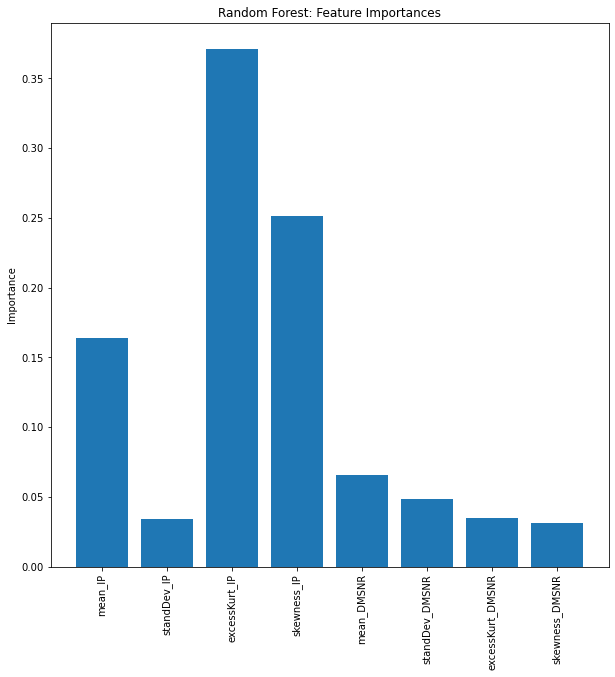

In [33]:
plt.rcParams['figure.figsize'] = [10, 10]
x = list(range(len(importances)))

# Make a bar chart
plt.bar(x, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.title('Random Forest: Feature Importances')
plt.savefig(path + '/output/rf_feature_importance.png', bbox_inches='tight')
plt.show()